In [1]:
from train_util import *
import torch
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE =40# 40 is also fine

LEARNING_RATE = 1e-4

EPOCHS = 400

MODEL_SAVE_PATH = "./models/model_unet1.pth"

In [2]:
xdata, ydata, test_xdata, test_ydata = get_data(None, ['train/1'], 'data')

train_dataset = MF_Dataset(xdata, ydata)
test_dataset = MF_Dataset(test_xdata, test_ydata)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2], generator=generator)

train_dataloader = DataLoader(dataset=train_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)
val_dataloader   = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader  = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)


model = u_net(in_channels=1, feat=32).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = nn.MSELoss()

In [6]:
history = {'train_loss': [], 'val_loss': []}
best_val_loss = None

for epoch in range(EPOCHS):
    tic = time.time()
    model.train()
    train_running_loss = 0
    for idx, xydata in enumerate((train_dataloader)):
        _xdata = xydata[0].float().to(device).squeeze(dim=1)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata) 
        optimizer.zero_grad()

        loss = criterion(y_pred, _ydata)
        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    
    scheduler.step()
    
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for idx, xydata in enumerate(val_dataloader):
            _xdata = xydata[0].float().to(device).squeeze(dim=1)
            _ydata = xydata[1].float().to(device)

            y_pred = model(_xdata)
            loss = criterion(y_pred, _ydata)

            val_running_loss += loss.item()
        val_loss = val_running_loss / (idx + 1)

    elapse = time.time() - tic

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    if best_val_loss is None or val_loss < best_val_loss:
        torch.save(model.state_dict(), MODEL_SAVE_PATH) # official recommended
        best_val_loss = val_loss
        
    if epoch % 10 == 0:
        print(f"Train Loss EPOCH {(epoch+1):6d}: {train_loss:6.4e} | Valid Loss EPOCH {(epoch+1):6d}: {val_loss:6.4e} | time: {elapse: 6.4f}")

Train Loss EPOCH      1: 1.5030e+00 | Valid Loss EPOCH      1: 1.5004e+00 | time:  0.8824
Train Loss EPOCH     11: 3.4008e-01 | Valid Loss EPOCH     11: 3.3242e-01 | time:  0.5356
Train Loss EPOCH     21: 2.1084e-01 | Valid Loss EPOCH     21: 2.2680e-01 | time:  0.5374
Train Loss EPOCH     31: 1.8863e-01 | Valid Loss EPOCH     31: 1.8628e-01 | time:  0.5414
Train Loss EPOCH     41: 1.7872e-01 | Valid Loss EPOCH     41: 1.7375e-01 | time:  0.5454
Train Loss EPOCH     51: 1.6512e-01 | Valid Loss EPOCH     51: 1.6290e-01 | time:  0.5479
Train Loss EPOCH     61: 1.4372e-01 | Valid Loss EPOCH     61: 1.4130e-01 | time:  0.5465
Train Loss EPOCH     71: 1.3533e-01 | Valid Loss EPOCH     71: 1.4988e-01 | time:  0.5487
Train Loss EPOCH     81: 1.3018e-01 | Valid Loss EPOCH     81: 1.3347e-01 | time:  0.5493
Train Loss EPOCH     91: 1.3170e-01 | Valid Loss EPOCH     91: 1.3070e-01 | time:  0.5521
Train Loss EPOCH    101: 1.2615e-01 | Valid Loss EPOCH    101: 1.2940e-01 | time:  0.5531
Train Loss

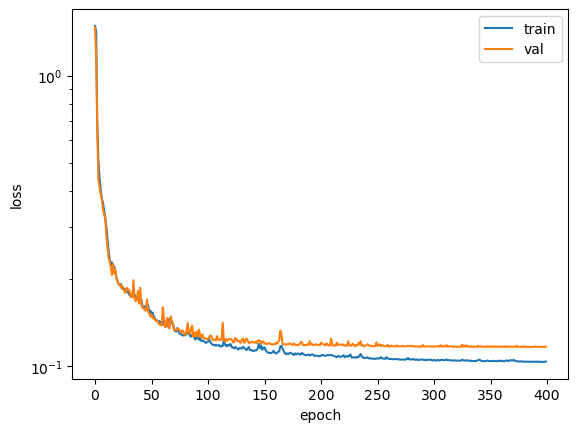

In [4]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log',base=10) 
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [5]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH), strict=True)
model.eval()

test_running_loss = 0

with torch.no_grad():

    for idx, xydata in enumerate(test_dataloader):
        _xdata = xydata[0].float().to(device)
        _ydata = xydata[1].float().to(device)

        y_pred = model(_xdata)
        loss = criterion(y_pred, _ydata)

        test_running_loss += loss.item()
        test_loss = test_running_loss / (idx + 1)

    print(test_loss)

0.10340257237354915


In [6]:
gen_data('out/1', 'train/1', None, 'data', model)

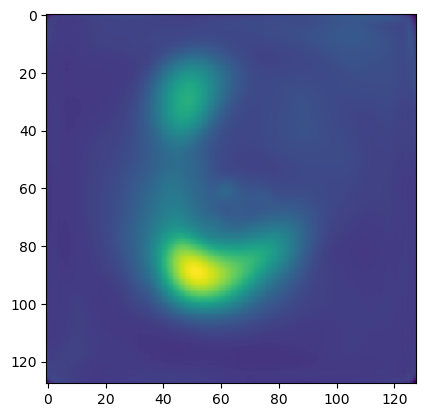

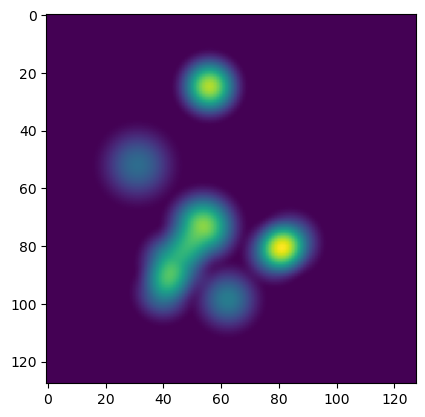

In [7]:
id = 2
img = scipy.io.loadmat(os.path.join('out/1', 'train_'+str(id) +'.mat'))['value']
plt.imshow(img)
plt.show()
img = scipy.io.loadmat(os.path.join('data', 'data_'+str(id) +'.mat'))['value']
plt.imshow(img)
plt.show()